# Inference on pretrained SSD model using Tensor Cores

In [5]:
## Lets import libraries we will use to prepare an input image.
import numpy as np
from matplotlib import pyplot as plt
import torch
%matplotlib inline
## From our examples we can import utility functions for inference:
from dle.inference import load_image, rescale, crop_center, normalize
from examples.SSD300_inference import load_checkpoint, build_predictor
from apex.fp16_utils import network_to_half
from ssd.utils import dboxes300_coco, Encoder
import matplotlib.patches as patches
import json

## Set Parameters

In [6]:
# Parameters
#model_path = '../checkpoints/rsd_first_448/epoch_100.pt'
model_path = '../checkpoints/rsd_four_556/epoch_25.pt'
# model_path = '../checkpoints/coco/epoch_19.pt'
# model_path = '../checkpoints/oneimgtest/epoch_250.pt'
classes_num = 6
# classes_num = 81
dataset_path = '../data/rsdcoco/images/test'
# dataset_path = '../data/coco/images/test2014'
#image_path = '../data/rsdcoco/images/val/airbase_13_jpg.rf.b2af10b9377d6e4cd7fbfc152da86906.jpg'
image_path = ['../data/rsdcoco/images/val/airbase_13_jpg.rf.b2af10b9377d6e4cd7fbfc152da86906.jpg',
              '../data/rsdcoco/images/val/helicopter_1871_jpg.rf.efd4a65a6451d252a742ab9051e4c703.jpg',
              '../data/rsdcoco/images/val/oiltank_4672_jpg.rf.381ba7343ef8dadf5b39d74feb3e6875.jpg',
              '../data/rsdcoco/images/val/plane_5788_jpg.rf.a3df09e17b2575a54e7fd318fe18d2e6.jpg',
              '../data/rsdcoco/images/val/warship_8631_jpg.rf.bebc82bf7e535f855d26fb0167bf2820.jpg']
# image_path = '../data/coco/images/val2014/COCO_val2014_000000001369.jpg'
json_file = '../data/rsdcoco/annotations/instances_val.json'
# json_file = '../data/coco/annotations/instances_val2014.json'
save_path = '../interference/rsd'
# save_path = '../interference/coco'

## Building an predictor

In [7]:
## We have prepared our imput. Next thing is to load a SSD model. In our examples you can find some framework specific functions. Some of them will be explained here in detail.
## Now we can import the model. We need to set it in the evaluation mode also:
ssd300 = build_predictor(model_path, classes_num)
ssd300 = ssd300.cuda()
ssd300 = network_to_half(ssd300.cuda())
ssd300 = ssd300.eval()

## Loading an image

<Figure size 640x480 with 0 Axes>

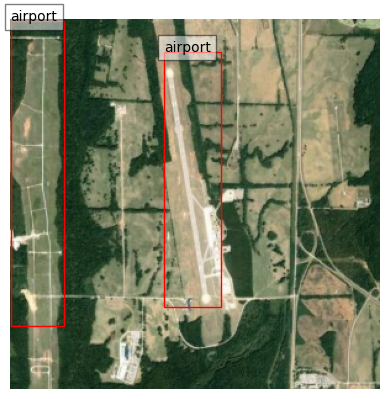

<Figure size 640x480 with 0 Axes>

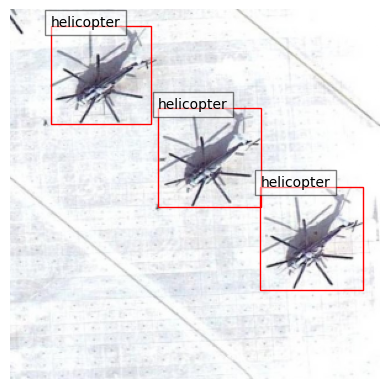

<Figure size 640x480 with 0 Axes>

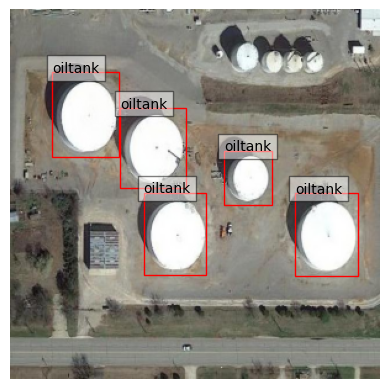

<Figure size 640x480 with 0 Axes>

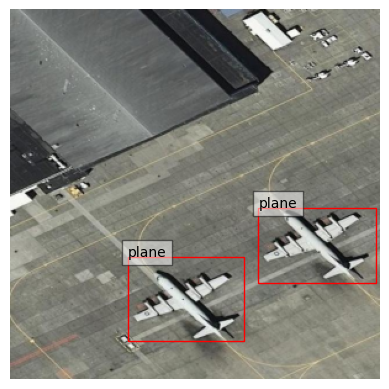

<Figure size 640x480 with 0 Axes>

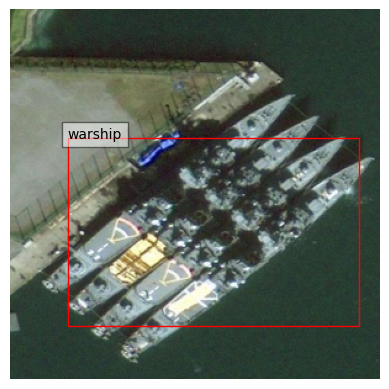

In [8]:
image_path = [image_path] if type(image_path) is str else image_path
for img_pth in image_path:
    # Loading an image
    img = load_image(img_pth)
    #plt.imshow(img)
    #plt.figure()
    ## Next we will rescale it, crop it and normalize it, so the model will get the expected input:
    img = rescale(img, 300, 300)
    img = crop_center(img, 300, 300)
    img = normalize(img)
    #plt.imshow(img)
    plt.figure()
    ## I looks weird, because after normalization, data values are in range [-1..1]. Plotting lib expects values from [0..1] range. We can fix it for visualization purpose:
    out = img/2+0.5
    #plt.imshow(out)
    #img.shape
    # change the shape
    HWC = img
    CHW = np.swapaxes(np.swapaxes(HWC, 0, 2), 1, 2)
    # make a batch of 1 image
    batch = np.expand_dims(CHW, axis=0)
    # turn input into tensor
    tensor = torch.from_numpy(batch)
    tensor = tensor.cuda()
    tensor = tensor.half()
    tensor.shape
    prediction = ssd300(tensor)
    dboxes = dboxes300_coco()
    encoder = Encoder(dboxes)
    ploc, plabel = [val.float() for val in prediction]
    encoded = encoder.decode_batch(ploc, plabel, criteria=0.5, max_output=5)
    bboxes, classes, confidences = [x.detach().cpu().numpy() for x in encoded[0]]
    best = np.argwhere(confidences > 0.3).squeeze(axis=1)
    with open(json_file,'r') as COCO:
        js = json.loads(COCO.read())
    class_names = [ category['name'] for category in js['categories'] ]
    fig,ax = plt.subplots(1)
    ax.imshow(out)
    plt.axis('off')
    for idx in best:
        left, top, right, bottom = bboxes[idx]
        x, y, w, h = [val*300 for val in [left, top, right-left, bottom-top]]
        rect = patches.Rectangle((x, y),w,h,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, class_names[classes[idx]-1], bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

## Interference on dataset

In [5]:
import os
files = os.listdir(dataset_path)
for img_path in files:
    img = load_image(dataset_path+'/'+img_path)
    img = rescale(img, 300, 300)
    img = crop_center(img, 300, 300)
    img = normalize(img)
    out = img/2+0.5
    # change the shape
    HWC = img
    CHW = np.swapaxes(np.swapaxes(HWC, 0, 2), 1, 2)
    # make a batch of 1 image
    batch = np.expand_dims(CHW, axis=0)
    # turn input into tensor
    tensor = torch.from_numpy(batch)
    tensor = tensor.cuda()
    tensor = tensor.half()
    tensor.shape
    prediction = ssd300(tensor)
    dboxes = dboxes300_coco()
    encoder = Encoder(dboxes)
    ploc, plabel = [val.float() for val in prediction]
    encoded = encoder.decode_batch(ploc, plabel, criteria=0.5, max_output=5)
    bboxes, classes, confidences = [x.detach().cpu().numpy() for x in encoded[0]]
    best = np.argwhere(confidences > 0.3).squeeze(axis=1)
    with open(json_file,'r') as COCO:
        js = json.loads(COCO.read())
    class_names = [ category['name'] for category in js['categories'] ]
    plt.close()
    fig,ax = plt.subplots(1)
    ax.imshow(out)
    plt.axis('off')
    for idx in best:
        left, top, right, bottom = bboxes[idx]
        x, y, w, h = [val*300 for val in [left, top, right-left, bottom-top]]
        rect = patches.Rectangle((x, y),w,h,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, class_names[classes[idx]-1], bbox=dict(facecolor='white', alpha=0.5))
        image_name = image_path
    plt.savefig(save_path + '/'+ img_path)
    #plt.show()
    plt.close()
    #break


KeyboardInterrupt: 